# Imports

In [1]:
import sys
sys.path.append('../')

In [2]:
import os

In [3]:
from tqdm import tqdm_notebook as tqdm
import seaborn as sns
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from torch.utils.tensorboard import SummaryWriter

from transformers.tokenization_bert import BertTokenizer
from transformers.modeling_bert import BertForTokenClassification, BertConfig, BertModel

In [4]:
from mlpack.datasets.conll2003 import get_conll2003, get_conll2003_features, convert_examples_to_features_masked
from mlpack.datasets.conll2003 import CoNLL2003Dataset, InputFeatures
from mlpack.bert.ner.model import BertForMaskedNERClassification, BertForNERClassification
from mlpack.bert.ner.train import train
from mlpack.bert.ner.utils import to_fp16, to_device
from mlpack.utils import save_pickle, read_pickle

# Tokenizer

In [5]:
tokenizer = BertTokenizer('../bert-base-cased/vocab.txt')

# Data

In [6]:
def get_all_words_set_from_examples(examples):
    words = sum([
        ex.text_a.split(' ') for ex in examples
    ], [])
    return list(set(words))

In [7]:
examples, labels = get_conll2003('../datasets/CoNLL2003/')

In [8]:
train_words = get_all_words_set_from_examples(examples['train'])
valid_words = get_all_words_set_from_examples(examples['valid'])

In [9]:
len(valid_words), len([w for w in valid_words if w in train_words])

(9966, 6706)

In [10]:
label_map = {i:l for i, l in enumerate(labels, 0)}
label_map

{0: '[PAD]',
 1: 'O',
 2: 'B-MISC',
 3: 'I-MISC',
 4: 'B-PER',
 5: 'I-PER',
 6: 'B-ORG',
 7: 'I-ORG',
 8: 'B-LOC',
 9: 'I-LOC',
 10: '[CLS]',
 11: '[SEP]',
 12: 'X'}

In [11]:
feat_attrs = ['input_ids', 'input_mask', 'segment_ids', 'label_id', 'valid_ids', 'label_mask', 'masked_word']
def features_to_pickle(features, filename):
    feats = [
        { attr: feat.__getattribute__(attr) for attr in feat_attrs }
        for feat in features
    ]
    save_pickle(feats, filename)
    
def pickle_to_features(filename):
    feats = read_pickle(filename)
    return [
        InputFeatures(**attrs) for attrs in feats
    ]

In [12]:
train_pickle = 'train_feats.pickle'
valid_pickle = 'valid_feats.pickle'
# if os.path.exists(train_pickle):
#     features_train = pickle_to_features(train_pickle)
# else:
#     features_train = convert_examples_to_features_masked(examples['train'], labels, 128, tokenizer)
#     features_to_pickle(features_train, train_pickle)
    
if os.path.exists(valid_pickle):
    features_valid = pickle_to_features(valid_pickle)
else:
    features_valid = convert_examples_to_features_masked(examples['valid'], labels, 128, tokenizer)
    features_to_pickle(features_valid, valid_pickle)
    

In [13]:
train_normal_features = convert_examples_to_features_masked

In [14]:
# valid features with masked word on train
onmask_feats = [
    feat for feat in features_valid if feat.masked_word in train_words
]

offmask_feats = [
    feat for feat in features_valid if feat.masked_word not in train_words
]

In [15]:
len(onmask_feats), len(offmask_feats)

(47038, 4285)

# Checking

In [18]:
idx = 2
ex, feat = examples['valid'][idx], features_valid[idx]

In [20]:
zipped = zip(tokenizer.convert_ids_to_tokens(feat.input_ids), feat.label_mask,
            feat.input_mask)
for tok, lm, im in zipped:
    print(f'{tok:10} {lm} {im}')

[CLS]      0 1
cricket    0 1
-          0 1
[MASKU]    1 1
take       0 1
over       0 1
at         0 1
top        0 1
after      0 1
innings    0 1
victory    0 1
.          0 1
[SEP]      0 1
[PAD]      0 0
[PAD]      0 0
[PAD]      0 0
[PAD]      0 0
[PAD]      0 0
[PAD]      0 0
[PAD]      0 0
[PAD]      0 0
[PAD]      0 0
[PAD]      0 0
[PAD]      0 0
[PAD]      0 0
[PAD]      0 0
[PAD]      0 0
[PAD]      0 0
[PAD]      0 0
[PAD]      0 0
[PAD]      0 0
[PAD]      0 0
[PAD]      0 0
[PAD]      0 0
[PAD]      0 0
[PAD]      0 0
[PAD]      0 0
[PAD]      0 0
[PAD]      0 0
[PAD]      0 0
[PAD]      0 0
[PAD]      0 0
[PAD]      0 0
[PAD]      0 0
[PAD]      0 0
[PAD]      0 0
[PAD]      0 0
[PAD]      0 0
[PAD]      0 0
[PAD]      0 0
[PAD]      0 0
[PAD]      0 0
[PAD]      0 0
[PAD]      0 0
[PAD]      0 0
[PAD]      0 0
[PAD]      0 0
[PAD]      0 0
[PAD]      0 0
[PAD]      0 0
[PAD]      0 0
[PAD]      0 0
[PAD]      0 0
[PAD]      0 0
[PAD]      0 0
[PAD]      0 0
[PAD]     

# Dataset

In [18]:
ds_train = CoNLL2003Dataset(features_train)
ds_valid = CoNLL2003Dataset(features_valid)
ds_offvalid = CoNLL2003Dataset(offmask_feats)

In [19]:
dl_train = DataLoader(ds_train, batch_size=32, pin_memory=True, shuffle=True,  num_workers=4)
dl_valid = DataLoader(ds_valid, batch_size=32, pin_memory=True, shuffle=False, num_workers=4)
dl_offvalid = DataLoader(ds_offvalid, batch_size=32, pin_memory=True, shuffle=False, num_workers=4)

# Evaluating

In [20]:
import numpy as np
from sklearn.metrics import confusion_matrix

In [33]:
def evaluate_fn(model, dataloader, return_conf=False):
    model.eval()
    losses, accuracies = [], []
    y_trues, y_preds = [], []
    for input_ids, input_mask, label_ids, label_mask in tqdm(dataloader, desc='Evaluating', leave=False):
        input_ids, input_mask, label_ids, label_mask = to_device(input_ids, input_mask, label_ids,
                                                                 label_mask, device=device)
        with torch.no_grad():
            loss, active_logits, active_labels = model(
                input_ids, input_mask, label_ids, label_mask)
            
        losses.append(loss.item())
        
        active_logits = active_logits.argmax(dim=1).cpu().numpy()
        active_labels = active_labels.cpu().numpy()
        accs = (1 * (active_logits == active_labels)).tolist()
        
        y_trues += active_labels.tolist()
        y_preds += active_logits.tolist()
        accuracies += accs
        
    conf = confusion_matrix([LABELS[y] for y in y_trues], [LABELS[y] for y in y_preds], labels=LABELS)
    if return_conf:
        return conf
    print(conf)
        
        # transforming
#         ts, ps = remap(input_ids, input_mask, label_ids, label_mask, active_logits, active_labels)
#         y_preds += ps
#         y_trues += ts
        
#     print(y_preds, y_trues)
#     print(classification_report(y_trues, y_preds))
            
    return np.array(losses).mean(), np.array(accuracies).mean()

# Bert Model

Lets do this with the X tag for training and evaluation

In [22]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = 'cpu'

In [22]:
LABELS = [
    l for l in labels if l not in ['[PAD]', '[CLS]', '[SEP]', 'X']
]
LABELS, len(LABELS)

(['O',
  'B-MISC',
  'I-MISC',
  'B-PER',
  'I-PER',
  'B-ORG',
  'I-ORG',
  'B-LOC',
  'I-LOC'],
 9)

In [28]:
config = BertConfig.from_pretrained('../bert-base-cased/', num_labels=len(LABELS), output_hidden_states=True)

In [25]:
class BertLSTMForMaskedNerClassification(BertForMaskedNERClassification):
    
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
        del self.classifier, self.dropout
        
        self.lstm = nn.LSTM(
            input_size=768,
            hidden_size=100,
            num_layers=2,
            batch_first=True,
            dropout=0.1,
            bidirectional=True
        )
        
    def forward(self, input_ids, input_mask, label_ids, label_mask):

        _, _, hidden_states = self.bert(input_ids, attention_mask=input_mask)

        out = self.pooler(hidden_states)

        out, _ = self.lstm(out)
        # take the active logits
        label_mask = label_mask.view(-1)
        active_logits = out.view(-1, self.num_labels)[label_mask == 1]

        # take the active labels
        # remove one because of the [PAD] being the 0 moved to DATASET
        active_labels = label_ids.view(-1)[label_mask == 1]

        # calc the loss
        loss = self.loss_fct(active_logits, active_labels)

        return loss, active_logits, active_labels

In [26]:
model = BertForMaskedNERClassification(config, weight_O=0.1)

In [68]:
model.to(device)

BertForMaskedNERClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

In [58]:
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5, weight_decay=0)

In [77]:
conf = evaluate_fn(model, dl_valid, False)

[[36241    16   162   650  1764  1413  1619    60   808]
 [  804    70     2    16     3    22     1     2     2]
 [  164     0    65     0    23     0    66     0    28]
 [  906     0     1   789    88    32    17     1     2]
 [  166     0     0    12  1061     0    34     0    27]
 [  744     1     0    27     2   543    17     4     3]
 [  135     0     6     0    36    14   519     0    41]
 [ 1470     1     1    43    19   103    12   174    14]
 [   59     0     3     2    14     0    33     0   146]]


In [78]:
conf

(4.421811970256108, 0.7717397657970111)

In [39]:
import matplotlib.pyplot as plt

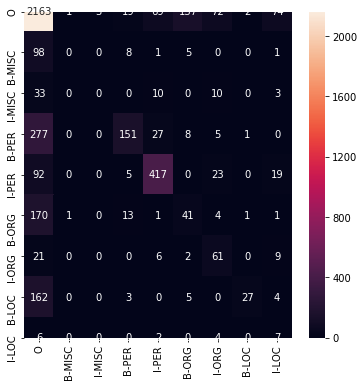

In [73]:
plt.figure(figsize=(6,6))
sns.heatmap(conf, annot=True, fmt='d', yticklabels=LABELS, xticklabels=LABELS)

# Training

In [69]:
scheduler = None

In [47]:
class Args:
    device = device
    fp16 = True
    num_epochs = 10
    ckp_path = 'bertner_masked_2.ckp'
    grad_steps = 1
    max_grad_norm = 1.
    load_state_dict = True
    n_iter = 0
    best_acc = 0.86
    writer = SummaryWriter('nerbert_masked_2')
    epoch = 0
args = Args()

In [62]:
if args.fp16:# and args.n_iter == 0:
    model, optimizer = to_fp16(model, optimizer)

Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic


In [71]:
if args.load_state_dict:
    if os.path.exists('bertner_lastlayer.ckp'):
        print(model.load_state_dict(torch.load('bertner_lastlayer.ckp'), strict=False))
#     if os.path.exists(args.ckp_path.replace('.ckp', '_optimizer.ckp')):
#         optimizer.load_state_dict(torch.load(args.ckp_path.replace('.ckp', '_optimizer.ckp'), map_location='cpu'))

_IncompatibleKeys(missing_keys=['loss_fct.weight'], unexpected_keys=[])


In [64]:
train(args, model, dl_train, dl_valid, optimizer, evaluate_fn=evaluate_fn)

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0


KeyboardInterrupt: 